In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from collections import OrderedDict
from sklearn.metrics import accuracy_score
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import concatenate
from keras.layers import Bidirectional

In [4]:
def lag(x,y,z):
    WINDOW = z
    for window in WINDOW:
        x['{}_Window_{}'.format(y,window)] = x[y].rolling(window).mean()

In [5]:
def bestfit(x):
    model_ = auto_arima(x, trace= True)
    model_.summary()

In [6]:
def arima(x,y):
    model = ARIMA(x, order= y)
    model = model.fit()
    model.summary()
    predict = model.predict(start = len(train), end = len(train)+ len(test) - 1, typ = 'levels')
    return predict

In [7]:
def pred_plot(x,y):
    x.plot()
    y.plot()

In [8]:
def rmse(x,y):
    rmse = sqrt(mean_squared_error(x,y))
    return rmse

In [9]:
def binary_pred_acc(x):
    pred = pd.DataFrame()
    pred['predict'] = x
    pred['close_binary'] = np.where(pred['predict']>x.mean(), 1, 0)
    acc = accuracy_score(df['close_binary'].iloc[-187:],pred['close_binary'])
    return acc

filtering warning did not work idk why

# Bitcoin 

#### Close with stationary with lag window of 7

In [23]:
data = pd.read_csv('Ethereum_Google_Trends.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [24]:
data['returns_close'] = ((data['Close'] - data['Close'].shift(1))/data['Close'])*100
data = data.dropna()
data['returns_trend'] = ((data['Trend'] - data['Trend'].shift(1))/data['Trend'])*100
data = data.dropna()
data['close_binary'] = np.where(data['returns_close']>0, 1, 0)

In [25]:
lag(data,'returns_close',[3,7])
data = data.dropna()
lag(data,'returns_trend',[3,7])
data = data.dropna()

In [26]:
data.columns

Index(['Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'Trend', 'returns_close', 'returns_trend', 'close_binary',
       'returns_close_Window_3', 'returns_close_Window_7',
       'returns_trend_Window_3', 'returns_trend_Window_7'],
      dtype='object')

In [27]:
df = pd.DataFrame()
df[['close','trend','lag_close3','lag_close7','lag_trend3','lag_trend7']] = data[['returns_close','returns_trend','returns_close_Window_3','returns_close_Window_7','returns_trend_Window_3','returns_trend_Window_7']]

In [28]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [29]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_days = 3
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(1937, 24)


C:\Users\rohit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\rohit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='var1(t)', ylabel='Density'>

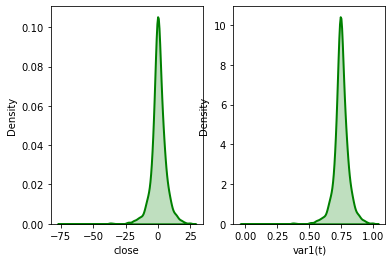

In [30]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
sns.distplot(df['close'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax=ax[0])
sns.distplot(reframed['var1(t)'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax=ax[1])

In [31]:
# split into train and test sets
values = reframed.values
n_train = 1750
train = values[:n_train, :]
test = values[n_train:, :]

In [32]:
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(1750, 18) 1750 (1750,)


In [33]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1750, 3, 6) (1750,) (187, 3, 6) (187,)


Epoch 1/100
55/55 - 14s - loss: 0.1333 - val_loss: 0.0072 - 14s/epoch - 254ms/step
Epoch 2/100
55/55 - 1s - loss: 0.0049 - val_loss: 0.0063 - 674ms/epoch - 12ms/step
Epoch 3/100
55/55 - 1s - loss: 0.0045 - val_loss: 0.0057 - 669ms/epoch - 12ms/step
Epoch 4/100
55/55 - 1s - loss: 0.0041 - val_loss: 0.0053 - 668ms/epoch - 12ms/step
Epoch 5/100
55/55 - 1s - loss: 0.0040 - val_loss: 0.0052 - 653ms/epoch - 12ms/step
Epoch 6/100
55/55 - 1s - loss: 0.0039 - val_loss: 0.0051 - 663ms/epoch - 12ms/step
Epoch 7/100
55/55 - 1s - loss: 0.0039 - val_loss: 0.0051 - 657ms/epoch - 12ms/step
Epoch 8/100
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 690ms/epoch - 13ms/step
Epoch 9/100
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 652ms/epoch - 12ms/step
Epoch 10/100
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 703ms/epoch - 13ms/step
Epoch 11/100
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 696ms/epoch - 13ms/step
Epoch 12/100
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 590ms/epoch - 11ms/step
E

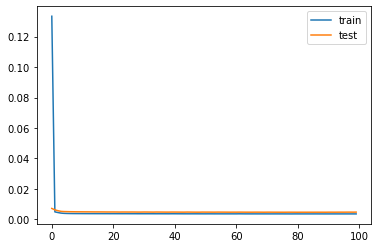

In [34]:
# design network
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [36]:
df_pred = pd.DataFrame()
df_pred['close'] = df['close'].iloc[-187:]
df_pred = df_pred.reset_index(drop=True)  
df_pred['Prediction_lstm'] = inv_yhat

In [43]:
new_df = reframed.iloc[:,:-(n_features-1)]
new_df = new_df.rename(columns={'var1(t-2)': 'close(t-2)', 'var2(t-2)': 'trend(t-2)', 'var3(t-2)': 'lag_close3(t-2)', 
                                'var4(t-2)': 'lag_close7(t-2)', 'var5(t-2)': 'lag_trend3(t-2)','var6(t-2)': 'lag_trend7(t-2)',
                                'var1(t-1)': 'close(t-1)', 'var2(t-1)': 'trend(t-1)', 'var3(t-1)': 'lag_close3(t-1)', 
                                'var4(t-1)': 'lag_close7(t-1)', 'var5(t-1)': 'lag_trend3(t-1)', 
                                'var6(t-1)': 'lag_trend7(t-1)', 'var1(t)': 'close(t)'})
train = new_df.iloc[:1750,:]
test = new_df.iloc[1750:,:]
X_train = train.drop("close(t)", axis =1)
y_train = train['close(t)']
X_test = test.drop("close(t)", axis =1)
y_test = test['close(t)']

In [44]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

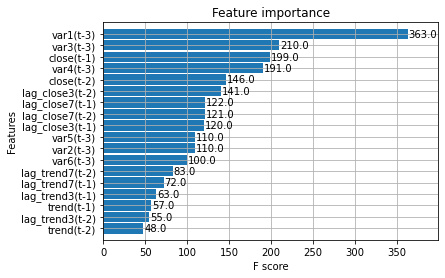

In [45]:
_ = plot_importance(reg, height=0.9)

In [46]:
Prediction_xgb = reg.predict(X_test)

In [47]:
Prediction_xgb = Prediction_xgb.reshape(-1,1)

In [48]:
inv_yhat = concatenate((Prediction_xgb, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [49]:
df_pred['Prediction_xgb'] = inv_yhat

In [50]:
bestfit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4895.547, Time=5.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4900.509, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4899.192, Time=1.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4899.144, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3952.907, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4897.021, Time=2.40 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 10.675 seconds


In [51]:
Prediction_arima = arima(y_train,(0,0,0))
Prediction_arima = Prediction_arima.values.reshape(-1,1)

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

In [52]:
inv_yhat = concatenate((Prediction_arima, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [53]:
df_pred['Prediction_arima'] = inv_yhat

In [66]:
df_pred['Ensemble'] = (df_pred['Prediction_xgb']+df_pred['Prediction_arima']+df_pred['Prediction_lstm'])/3

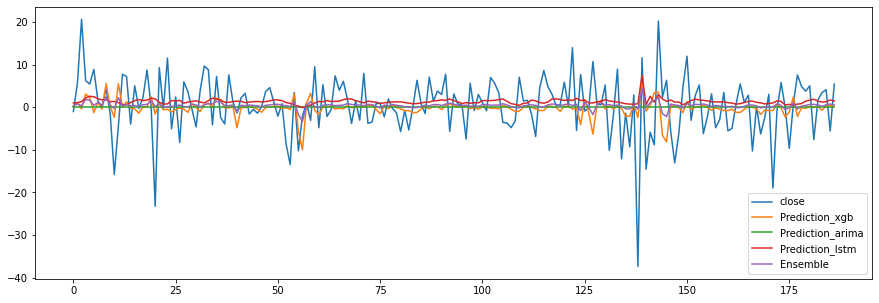

In [67]:
_ = df_pred[['close','Prediction_xgb','Prediction_arima','Prediction_lstm','Ensemble']].plot(figsize=(15, 5))

In [68]:
print('rmse for xgb: ',rmse(df_pred['Prediction_xgb'],df_pred['close']))
print('rmse for arima: ',rmse(df_pred['Prediction_arima'],df_pred['close']))
print('rmse for ensemble: ',rmse(df_pred['Ensemble'],df_pred['close']))
print('rmse for lstm: ',rmse(df_pred['Prediction_lstm'],df_pred['close']))

rmse for xgb:  6.864046491584547
rmse for arima:  6.835780910864449
rmse for ensemble:  6.75723765485368
rmse for lstm:  6.82445694260986


In [69]:
import numpy as np

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

print('mape for xgb: ',mape(df_pred['close'], df_pred['Prediction_xgb']))
print('mape for arima: ',mape(df_pred['close'], df_pred['Prediction_arima']))
print('mape for ensemble: ',mape(df_pred['close'], df_pred['Ensemble']))
print('mape for lstm: ',mape(df_pred['close'], df_pred['Prediction_lstm']))

mape for xgb:  152.1383760245694
mape for arima:  100.08865947263807
mape for ensemble:  107.42581912127436
mape for lstm:  144.7754967776893


Increasing the lag window does not seem to change the result, persuing this method does not seem to work

#### Long and short with no lag

In [ ]:
df = pd.DataFrame()
df[['close_binary','trend','lag_close3','lag_close7','lag_trend3','lag_trend7']] = data[['close_binary','returns_trend','returns_close_Window_3','returns_close_Window_7','returns_trend_Window_3','returns_trend_Window_7']]

In [ ]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_days = 3
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

C:\Users\rohit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\rohit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='var1(t)', ylabel='Density'>

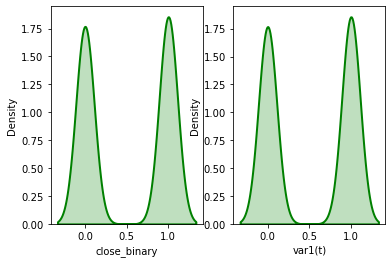

In [204]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
sns.distplot(df['close_binary'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax=ax[0])
sns.distplot(reframed['var1(t)'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax=ax[1])

In [206]:
# split into train and test sets
values = reframed.values
n_train = 1750
train = values[:n_train, :]
test = values[n_train:, :]

In [207]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1750, 3, 6) (1750,) (187, 3, 6) (187, 1)


Epoch 1/50
55/55 - 10s - loss: 0.1374 - val_loss: 0.0068 - 10s/epoch - 179ms/step
Epoch 2/50
55/55 - 1s - loss: 0.0052 - val_loss: 0.0064 - 567ms/epoch - 10ms/step
Epoch 3/50
55/55 - 1s - loss: 0.0047 - val_loss: 0.0061 - 572ms/epoch - 10ms/step
Epoch 4/50
55/55 - 1s - loss: 0.0043 - val_loss: 0.0054 - 570ms/epoch - 10ms/step
Epoch 5/50
55/55 - 1s - loss: 0.0041 - val_loss: 0.0052 - 580ms/epoch - 11ms/step
Epoch 6/50
55/55 - 1s - loss: 0.0040 - val_loss: 0.0051 - 558ms/epoch - 10ms/step
Epoch 7/50
55/55 - 1s - loss: 0.0039 - val_loss: 0.0051 - 563ms/epoch - 10ms/step
Epoch 8/50
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 575ms/epoch - 10ms/step
Epoch 9/50
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 573ms/epoch - 10ms/step
Epoch 10/50
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 561ms/epoch - 10ms/step
Epoch 11/50
55/55 - 1s - loss: 0.0038 - val_loss: 0.0050 - 567ms/epoch - 10ms/step
Epoch 12/50
55/55 - 1s - loss: 0.0038 - val_loss: 0.0049 - 565ms/epoch - 10ms/step
Epoch 13/50
5

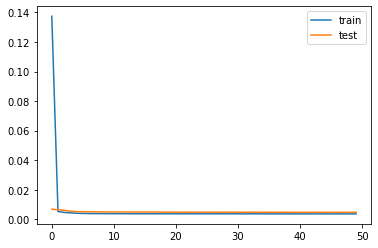

In [208]:
# design network
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [209]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [210]:
inv_yhat = concatenate((Prediction_xgb, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [211]:
binary_pred_acc(inv_yhat)

0.49732620320855614

In [212]:
new_df = reframed.iloc[:,:-(n_features-1)]
new_df = new_df.rename(columns={'var1(t-3)': 'close(t-3)', 'var2(t-3)': 'trend(t-3)', 'var3(t-3)': 'lag_close3(t-3)', 
                        'var4(t-3)': 'lag_close7(t-3)', 'var5(t-3)': 'lag_trend3(t-3)','var4(t-3)': 'lag_trend7(t-3)',
                        'var1(t-2)': 'close(t-2)', 'var2(t-2)': 'trend(t-2)', 'var3(t-2)': 'lag_close3(t-2)', 
                        'var4(t-2)': 'lag_close7(t-2)', 'var5(t-2)': 'lag_trend3(t-2)','var6(t-2)': 'lag_trend7(t-2)',
                        'var1(t-1)': 'close(t-1)', 'var2(t-1)': 'trend(t-1)', 'var3(t-1)': 'lag_close3(t-1)', 
                        'var4(t-1)': 'lag_close7(t-1)', 'var5(t-1)': 'lag_trend3(t-1)', 
                        'var6(t-1)': 'lag_trend7(t-1)', 'var1(t)': 'close(t)'})
train = new_df.iloc[:1750,:]
test = new_df.iloc[1750:,:]
X_train = train.drop("close(t)", axis =1)
y_train = train['close(t)']
X_test = test.drop("close(t)", axis =1)
y_test = test['close(t)']

In [213]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
reg = xgb.XGBClassifier(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

C:\Users\rohit\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

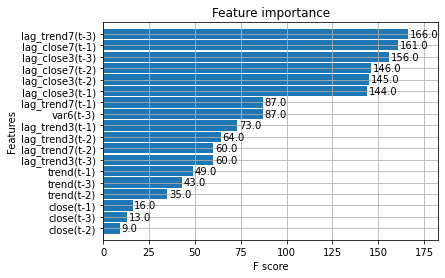

In [214]:
_ = plot_importance(reg, height=0.9)

In [215]:
Prediction_xgb = reg.predict(X_test)
Prediction_xgb = Prediction_xgb.reshape(-1,1)
inv_yhat = concatenate((Prediction_xgb, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [216]:
binary_pred_acc(inv_yhat)

0.47058823529411764

In [226]:
bestfit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2538.898, Time=5.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2543.993, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2536.994, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2537.266, Time=1.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3777.140, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2538.744, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2538.808, Time=1.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2535.836, Time=4.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2537.233, Time=5.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2535.565, Time=4.71 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2538.649, Time=0.80 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2537.175, Time=5.37 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2540.192, Time=0.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2539.288, Time=5.94 sec
 ARIMA(1,0,2)(0,0,0)[0]          

In [227]:
Prediction_arima = arima(y_train,(1,0,2))
Prediction_arima = Prediction_arima.values.reshape(-1,1)

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [224]:
inv_yhat = concatenate((Prediction_arima, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [225]:
binary_pred_acc(inv_yhat)

0.42780748663101603